# Hierarchical classification of papers

In [1]:
#importing the libraries
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
#Loading previously downloaded researcher info in .cvs format 

papers = pd.read_csv("GustavoDeco_MicrosoftAcedemic.csv", header=0)



In [3]:
# Preview the first 10 lines of the loaded data
papers.head(10)
#papers.head(0) # print only the header of table

,Cites,Authors,Title,Year,Source,Publisher,ArticleURL,CitesURL,GSRank,QueryDate,...,Volume,Issue,StartPage,EndPage,ECC,CitesPerYear,CitesPerAuthor,AuthorCount,Age,Abstract
0,1118,"Gustavo Deco, Viktor K Jirsa, Viktor K Jirsa, ...",Emerging concepts for the dynamical organizati...,2011,Nature Reviews Neuroscience,NaN,https://www.nature.com/articles/nrn2961,NaN,1,06/05/2020 21:15,...,12.0,1.0,43.0,56.0,1118,124.22,280,4,9,A broad body of experimental work has demonstr...
1,794,"Gustavo Deco, Viktor K Jirsa, P A Robinson, Mi...",The Dynamic Brain: From Spiking Neurons to Neu...,2008,PLOS Computational Biology,NaN,http://europepmc.org/articles/PMC2519166,NaN,2,06/05/2020 21:15,...,4.0,8.0,NaN,NaN,794,66.17,132,6,12,"The cortex is a complex system, characterized ..."
2,539,"Gustavo Deco, Viktor K Jirsa, Anthony R Mcinto...","Key role of coupling, delay, and noise in rest...",2009,Proceedings of the National Academy of Science...,NaN,http://europepmc.org/articles/PMC2690605,NaN,3,06/05/2020 21:15,...,106.0,25.0,10302.0,10307.0,539,49.00,108,5,11,A growing body of neuroimaging research has do...
3,437,"Gustavo Deco, Viktor K Jirsa",Ongoing Cortical Activity at Rest: Criticality...,2012,The Journal of Neuroscience,NaN,https://repositori.upf.edu/handle/10230/23077,NaN,5,06/05/2020 21:15,...,32.0,10.0,3366.0,3375.0,437,54.63,219,2,8,"The ongoing activity of the brain at rest, i.e..."
4,338,"Joana Cabral, Etienne Hugues, Olaf Sporns, Gus...",Role of local network oscillations in resting-...,2011,NeuroImage,NaN,https://doi.org/10.1016/j.neuroimage.2011.04.010,NaN,6,06/05/2020 21:15,...,57.0,1.0,130.0,139.0,338,37.56,85,4,9,Spatio-temporally organized low-frequency fluc...
5,292,"Gustavo Deco, Adrian Poncealvarez, Dante Manti...",Resting-State Functional Connectivity Emerges ...,2013,The Journal of Neuroscience,NaN,http://europepmc.org/articles/PMC3718368,NaN,7,06/05/2020 21:15,...,33.0,27.0,11239.0,11252.0,292,41.71,37,8,7,Brain fluctuations at rest are not random but ...
6,359,"Gustavo Deco, Edmund T Rolls",A Neurodynamical cortical model of visual atte...,2004,Vision Research,NaN,http://www.ncbi.nlm.nih.gov/pubmed/14693189,NaN,8,06/05/2020 21:15,...,44.0,6.0,621.0,642.0,359,22.44,180,2,16,We describe a model of invariant visual object...
7,313,"Rikkert Hindriks, Mohit H Adhikari, Yusuke Mur...",Can sliding-window correlations reveal dynamic...,2016,NeuroImage,NaN,http://europepmc.org/articles/PMC4758830,NaN,9,06/05/2020 21:15,...,127.0,NaN,242.0,256.0,313,78.25,35,9,4,"During the last several years, the focus of re..."
8,311,"Edmund T Rolls, Marco Loh, Gustavo Deco, Georg...",Computational models of schizophrenia and dopa...,2008,Nature Reviews Neuroscience,NaN,http://europepmc.org/abstract/MED/18714326,NaN,10,06/05/2020 21:15,...,9.0,9.0,696.0,709.0,311,25.92,78,4,12,Computational neuroscience models can be used ...
9,271,"Enrique C A Hansen, Demian Battaglia, Andreas ...",Functional connectivity dynamics: Modeling the...,2015,NeuroImage,NaN,http://pubman.mpdl.mpg.de/pubman/item/escidoc:...,NaN,11,06/05/2020 21:15,...,105.0,NaN,525.0,535.0,271,54.20,54,5,5,Abstract Functional connectivity (FC) sheds li...


In [4]:
# keyword extraction https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

dataset = pd.read_csv("GustavoDeco_MicrosoftAcedemic.csv", usecols = ["Title", "Year", "Abstract"] )
dataset.head()

,Title,Year,Abstract
0,Emerging concepts for the dynamical organizati...,2011,A broad body of experimental work has demonstr...
1,The Dynamic Brain: From Spiking Neurons to Neu...,2008,"The cortex is a complex system, characterized ..."
2,"Key role of coupling, delay, and noise in rest...",2009,A growing body of neuroimaging research has do...
3,Ongoing Cortical Activity at Rest: Criticality...,2012,"The ongoing activity of the brain at rest, i.e..."
4,Role of local network oscillations in resting-...,2011,Spatio-temporally organized low-frequency fluc...


In [5]:
#Fetch wordcount for each abstract
dataset['word_count'] = dataset['Abstract'].apply(lambda x: len(str(x).split(" ")))
dataset[['Abstract','word_count']].head()

,Abstract,word_count
0,A broad body of experimental work has demonstr...,114
1,"The cortex is a complex system, characterized ...",281
2,A growing body of neuroimaging research has do...,247
3,"The ongoing activity of the brain at rest, i.e...",36
4,Spatio-temporally organized low-frequency fluc...,342


In [6]:
##Descriptive statistics of word counts
dataset.word_count.describe()

#dataset.shape

count     390.000000
mean      191.066667
std        96.014864
min        11.000000
25%       138.500000
50%       186.000000
75%       240.000000
max      1068.000000
Name: word_count, dtype: float64

In [7]:
#Identify common words
freq = pd.Series(' '.join(dataset['Abstract']).split()).value_counts()[:20]
freq

the        4662
of         3225
and        1932
in         1723
a          1609
to         1564
that        904
is          816
for         610
with        553
by          549
brain       533
we          475
The         444
are         431
We          424
as          412
network     367
on          363
be          352
dtype: int64

In [8]:
#Identify uncommon words
freq1 =  pd.Series(' '.join(dataset 
         ['Abstract']).split()).value_counts()[-20:]
freq1

Renyi                   1
neurological            1
(Infomax-principle),    1
Issue                   1
perinatal               1
equipped                1
Recordings              1
projecting              1
range.                  1
depict                  1
separating              1
‘where’-like            1
resemblance             1
dramatically            1
rich-club               1
development.            1
switches                1
early,                  1
slow.                   1
(HMM)                   1
dtype: int64

In [9]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

lem = WordNetLemmatizer()
stem = PorterStemmer()

# eXAMPLE 
word = "inversely"
print("stemming:",stem.stem(word))
print("lemmatization:", lem.lemmatize(word, "v"))

stemming: invers
lemmatization: inversely


In [10]:
# STOPWORDS

#nltk.download() #<--- run only the first time to download nltk 

# Creating a list of stop words and adding custom stopwords
stop_words = nltk.corpus.stopwords.words('english')

#printing some expamples of commonly used stopwords 
print (stop_words[:40])


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this']


In [11]:
 dataset['Abstract'][1]

'The cortex is a complex system, characterized by its dynamics and architecture, which underlie many functions such as action, perception, learning, language, and cognition. Its structural architecture has been studied for more than a hundred years; however, its dynamics have been addressed much less thoroughly. In this paper, we review and integrate, in a unifying framework, a variety of computational approaches that have been used to characterize the dynamics of the cortex, as evidenced at different levels of measurement. Computational models at different space–time scales help us understand the fundamental mechanisms that underpin neural processes and relate these processes to neuroscience data. Modeling at the single neuron level is necessary because this is the level at which information is exchanged between the computing elements of the brain; the neurons. Mesoscopic models tell us how neural elements interact to yield emergent behavior at the level of microcolumns and cortical c

In [12]:
 dataset['Abstract'][2]


'A growing body of neuroimaging research has documented that, in the absence of an explicit task, the brain shows temporally coherent activity. This so-called “resting state” activity or, more explicitly, the default-mode network, has been associated with daydreaming, free association, stream of consciousness, or inner rehearsal in humans, but similar patterns have also been found under anesthesia and in monkeys. Spatiotemporal activity patterns in the default-mode network are both complex and consistent, which raises the question whether they are the expression of an interesting cognitive architecture or the consequence of intrinsic network constraints. In numerical simulation, we studied the dynamics of a simplified cortical network using 38 noise-driven (Wilson–Cowan) oscillators, which in isolation remain just below their oscillatory threshold. Time delay coupling based on lengths and strengths of primate corticocortical pathways leads to the emergence of 2 sets of 40-Hz oscillator

In [13]:

corpus = []
abstracts = papers['Abstract'].values
size = abstracts.size


array_abstracts = np.array(dataset['Abstract'])


for i in range(0, size):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', array_abstracts[i])
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    ##Stemming
    ps=PorterStemmer()
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in  
            stop_words] 
    text = " ".join(text)
    corpus.append(text)

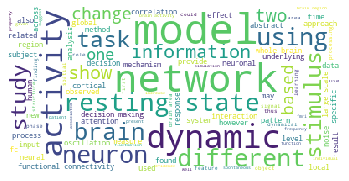

In [14]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=100, max_font_size=50, random_state=42).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
import re

cv = CountVectorizer(max_df = 1.0, stop_words = stop_words, max_features=10000, ngram_range=(1,3))
X = cv.fit_transform(corpus)

In [16]:
list(cv.vocabulary_.keys())[:10]


['broad',
 'body',
 'experimental',
 'work',
 'demonstrated',
 'apparently',
 'spontaneous',
 'brain',
 'activity',
 'random']

In [17]:
#Most frequently occuring words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      
                   vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                       reverse=True)
    return words_freq[:n]

In [18]:
#Convert most freq words to dataframe for plotting bar plot
top_words = get_top_n_words(corpus, n=20)
top_df = pd.DataFrame(top_words)
top_df.columns=["Word", "Freq"]

[Text(0, 0, 'brain'),
 Text(0, 0, 'network'),
 Text(0, 0, 'model'),
 Text(0, 0, 'state'),
 Text(0, 0, 'dynamic'),
 Text(0, 0, 'activity'),
 Text(0, 0, 'functional'),
 Text(0, 0, 'connectivity'),
 Text(0, 0, 'neuron'),
 Text(0, 0, 'information'),
 Text(0, 0, 'time'),
 Text(0, 0, 'task'),
 Text(0, 0, 'data'),
 Text(0, 0, 'resting'),
 Text(0, 0, 'different'),
 Text(0, 0, 'study'),
 Text(0, 0, 'neural'),
 Text(0, 0, 'area'),
 Text(0, 0, 'decision'),
 Text(0, 0, 'visual')]

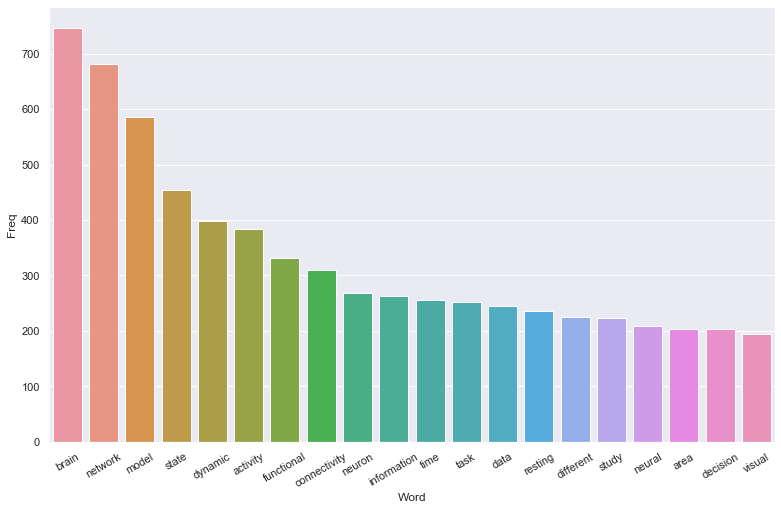

In [19]:
#Barplot of most freq words
import seaborn as sns
sns.set(rc={'figure.figsize':(13,8)})
g = sns.barplot(x="Word", y="Freq", data=top_df)
g.set_xticklabels(g.get_xticklabels(), rotation=30)

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
 
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(X)
# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc=corpus[1]
 
#generate tf-idf for the given document
tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))

In [21]:
#Based on the TF-IDF scores, we can extract the words with the highest scores to get the keywords for a document.
#Function for sorting tf_idf in descending order
from scipy.sparse import coo_matrix
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
 
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
 
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        feature_vals.append(feature_names[idx]) #keyword names
        
    
    return feature_vals

In [22]:
#sort the tf-idf vectors by descending order of scores
sorted_items=sort_coo(tf_idf_vector.tocoo())

#extract only the top n; n here is 10
keywords=extract_topn_from_vector(feature_names, sorted_items,5)
 
# now print the results
print("\nAbstract:")
print(doc)
print("\nKeywords:")
print(keywords)


#for k in keywords:
 #   print(k,keywords[k])


Abstract:
cortex complex system characterized dynamic architecture underlie many function action perception learning language cognition structural architecture studied hundred year however dynamic addressed much le thoroughly paper review integrate unifying framework variety computational approach used characterize dynamic cortex evidenced different level measurement computational model different space time scale help u understand fundamental mechanism underpin neural process relate process neuroscience data modeling single neuron level necessary level information exchanged computing element brain neuron mesoscopic model tell u neural element interact yield emergent behavior level microcolumns cortical column macroscopic model inform u whole brain dynamic interaction large scale neural system cortical region thalamus brain stem level description relates uniquely neuroscience data single unit recording local field potential functional magnetic resonance imaging fmri electroencephalogra

In [23]:
#------ showing some examples of the obtained keywords ------ 

# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
keywords = []
for i in range(0, 10):  #<--- only show the first 10 

    doc = corpus[i]
 
    #generate tf-idf for the given document
    tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
         
    #sort the tf-idf vectors by descending order of scores
    sorted_items = sort_coo(tf_idf_vector.tocoo())
        
                                          
    #extract only the top n; n here is 10
    paperKeywords = extract_topn_from_vector(feature_names, sorted_items, 10) #<--- number of keywords i want to get
 
    keywords.append(paperKeywords) #<------ storing my keywords here 
    
    # now print the results
    print("\nAbstract:")
    print(doc)
    
    print("\nKeywords:")
    print(keywords[i])
    


Abstract:
broad body experimental work demonstrated apparently spontaneous brain activity random level large scale neural system measured functional mri fmri ongoing activity reflects organization series highly coherent functional network called resting state network rsns closely relate underlying anatomical connectivity cannot understood term alone review three large scale neural system model primate neocortex emphasize key contribution local dynamic signal transmission delay noise emerging rsns propose formation dissolution resting state pattern reflects exploration possible functional network configuration around stable anatomical skeleton

Keywords:
['scale neural system', 'scale neural', 'large scale neural', 'reflects', 'neural system', 'rsns', 'functional network', 'anatomical', 'large scale', 'possible functional']

Abstract:
cortex complex system characterized dynamic architecture underlie many function action perception learning language cognition structural architecture stu

In [24]:
#------ iterate through all  abstracts to get all of the keywords ------ 

# get feature names
feature_names=cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
keywords = []
for i in range(0, size):  #<--- only show the first 10 

    doc = corpus[i]
 
    #generate tf-idf for the given document
    tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
         
    #sort the tf-idf vectors by descending order of scores
    sorted_items = sort_coo(tf_idf_vector.tocoo())
        
                                          
    #extract only the top n; n here is 10
    paperKeywords = extract_topn_from_vector(feature_names, sorted_items, 10) #<--- number of keywords i want to get
 
    keywords.append(paperKeywords) #<------ storing ALL my keywords here 
    
      

In [25]:
dataset = pd.read_csv("GustavoDeco_MicrosoftAcedemic.csv", usecols = ["Title", "Year", "Abstract"] )
dataset.head(10)


,Title,Year,Abstract
0,Emerging concepts for the dynamical organizati...,2011,A broad body of experimental work has demonstr...
1,The Dynamic Brain: From Spiking Neurons to Neu...,2008,"The cortex is a complex system, characterized ..."
2,"Key role of coupling, delay, and noise in rest...",2009,A growing body of neuroimaging research has do...
3,Ongoing Cortical Activity at Rest: Criticality...,2012,"The ongoing activity of the brain at rest, i.e..."
4,Role of local network oscillations in resting-...,2011,Spatio-temporally organized low-frequency fluc...
5,Resting-State Functional Connectivity Emerges ...,2013,Brain fluctuations at rest are not random but ...
6,A Neurodynamical cortical model of visual atte...,2004,We describe a model of invariant visual object...
7,Can sliding-window correlations reveal dynamic...,2016,"During the last several years, the focus of re..."
8,Computational models of schizophrenia and dopa...,2008,Computational neuroscience models can be used ...
9,Functional connectivity dynamics: Modeling the...,2015,Abstract Functional connectivity (FC) sheds li...


In [26]:
#Adding the keywords to the csv file 

keyword_arr = np.asarray(keywords) 

dataset["Keywords"] = keyword_arr
dataset.to_csv("sample.csv", index=False)
dataset.head(10)

,Title,Year,Abstract,Keywords
0,Emerging concepts for the dynamical organizati...,2011,A broad body of experimental work has demonstr...,"[scale neural system, scale neural, large scal..."
1,The Dynamic Brain: From Spiking Neurons to Neu...,2008,"The cortex is a complex system, characterized ...","[level, dynamic, model, neuroscience, element,..."
2,"Key role of coupling, delay, and noise in rest...",2009,A growing body of neuroimaging research has do...,"[sensitivity, oscillator, high sensitivity, co..."
3,Ongoing Cortical Activity at Rest: Criticality...,2012,"The ongoing activity of the brain at rest, i.e...","[spatiotemporal pattern, spatiotemporal, struc..."
4,Role of local network oscillations in resting-...,2011,Spatio-temporally organized low-frequency fluc...,"[empirically, gamma frequency range, frequency..."
5,Resting-State Functional Connectivity Emerges ...,2013,Brain fluctuations at rest are not random but ...,"[fc, dynamic, statistical moment, fc emerges, ..."
6,A Neurodynamical cortical model of visual atte...,2004,We describe a model of invariant visual object...,"[visual, feedback, attentional, area, stream, ..."
7,Can sliding-window correlations reveal dynamic...,2016,"During the last several years, the focus of re...","[dfc, session, statistical, sliding window cor..."
8,Computational models of schizophrenia and dopa...,2008,Computational neuroscience models can be used ...,"[schizophrenia, noise, symptom, trial, concept..."
9,Functional connectivity dynamics: Modeling the...,2015,Abstract Functional connectivity (FC) sheds li...,"[fc, state, non, stationarity, resting state, ..."


In [27]:
dataset['Abstract'][1]


'The cortex is a complex system, characterized by its dynamics and architecture, which underlie many functions such as action, perception, learning, language, and cognition. Its structural architecture has been studied for more than a hundred years; however, its dynamics have been addressed much less thoroughly. In this paper, we review and integrate, in a unifying framework, a variety of computational approaches that have been used to characterize the dynamics of the cortex, as evidenced at different levels of measurement. Computational models at different space–time scales help us understand the fundamental mechanisms that underpin neural processes and relate these processes to neuroscience data. Modeling at the single neuron level is necessary because this is the level at which information is exchanged between the computing elements of the brain; the neurons. Mesoscopic models tell us how neural elements interact to yield emergent behavior at the level of microcolumns and cortical c

In [28]:
dataset['Keywords'][1]


['level',
 'dynamic',
 'model',
 'neuroscience',
 'element',
 'emergent',
 'scale',
 'architecture',
 'characterize',
 'cortex']

In [29]:
# <----- Labtree code
#you can compute similarity/distance matrices between abstracts the way you want
#TfidfVectorizer and CountVectorizer methods can also provide you with most frequent words, keywords, word scores,...
import os
import urllib.request as urllib
import bs4
import re
import requests
import json
import subprocess
import pickle
import numpy as np
import plotly.graph_objs as go
import umap
import pandas as pd
import seaborn as sns
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from sklearn.datasets import load_iris
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from sklearn.cluster import DBSCAN
from scipy.sparse import csr_matrix
from scipy.spatial.distance import pdist,squareform
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

vect = TfidfVectorizer(max_df = .8,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
tfidf = vect.fit_transform(abstracts)
distance_matrix = np.abs(1-(tfidf@tfidf.T).A)
np.fill_diagonal(distance_matrix,0)

count = CountVectorizer(max_df = .8,lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
cv_fit=count.fit_transform(abstracts)

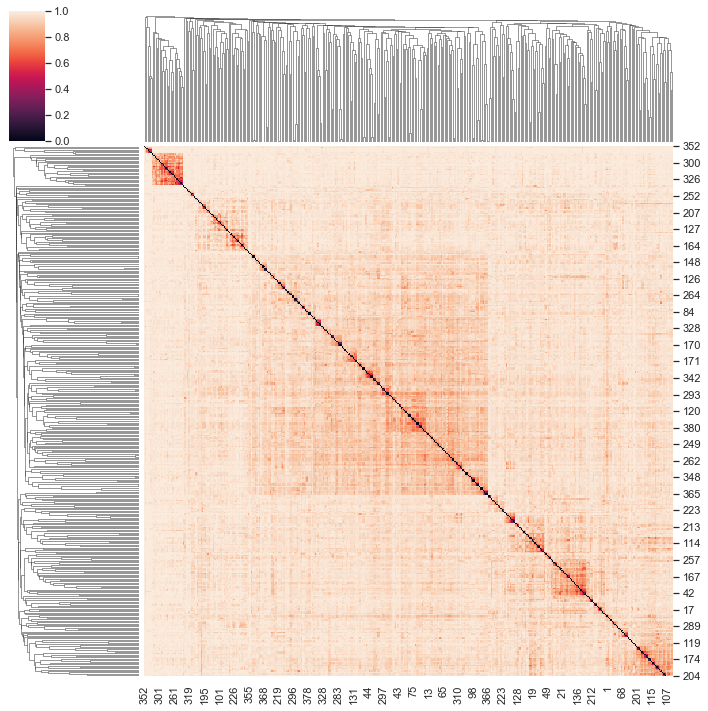

In [30]:
# clustering publications based on abstracts only 

linkage = hc.linkage(squareform(distance_matrix), method='average')
sns.clustermap(distance_matrix, row_linkage=linkage, col_linkage=linkage)